100%|██████████| 170M/170M [00:07<00:00, 23.7MB/s]


Device: cuda
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Epoch [1/10] Loss: 1.2947 | Test Acc: 62.79%
Epoch [2/10] Loss: 0.9236 | Test Acc: 67.48%
Epoch [3/10] Loss: 0.7463 | Test Acc: 71.55%
Epoch [4/10] Loss: 0.6056 | Test Acc: 71.94%
Epoch [5/10] Loss: 0.4691 | Test Acc: 72.98%
Epoch [6/10] Loss: 0.3429 | Test Acc: 72.54%
Epoch [7/10] Loss: 0.2419 | Test Acc: 71.80%
Epoch [8/10] Loss: 0.1581 | Test Acc: 72.01%
Epoch [9/10] Loss: 0.1146 | Test Acc: 71.29%
Epoch [10/10] Loss: 0.0893 | Test Acc: 71.97%
Huấn luyện xong!


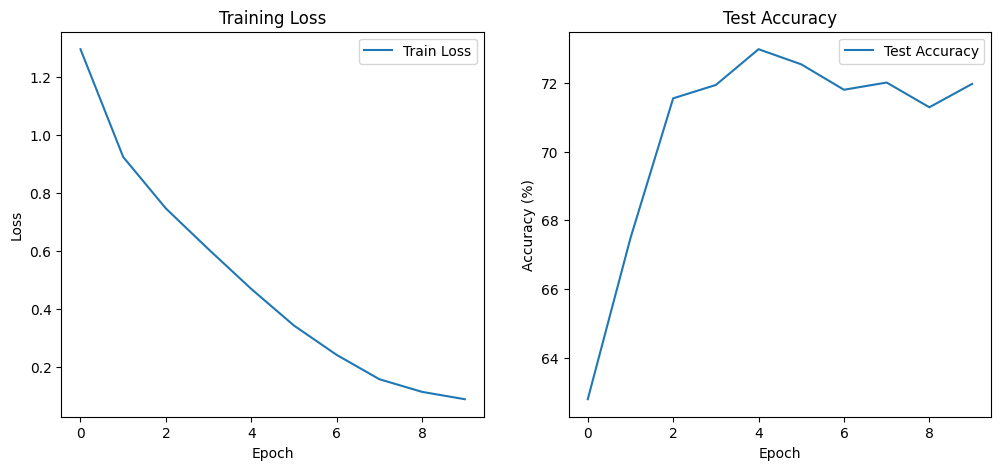

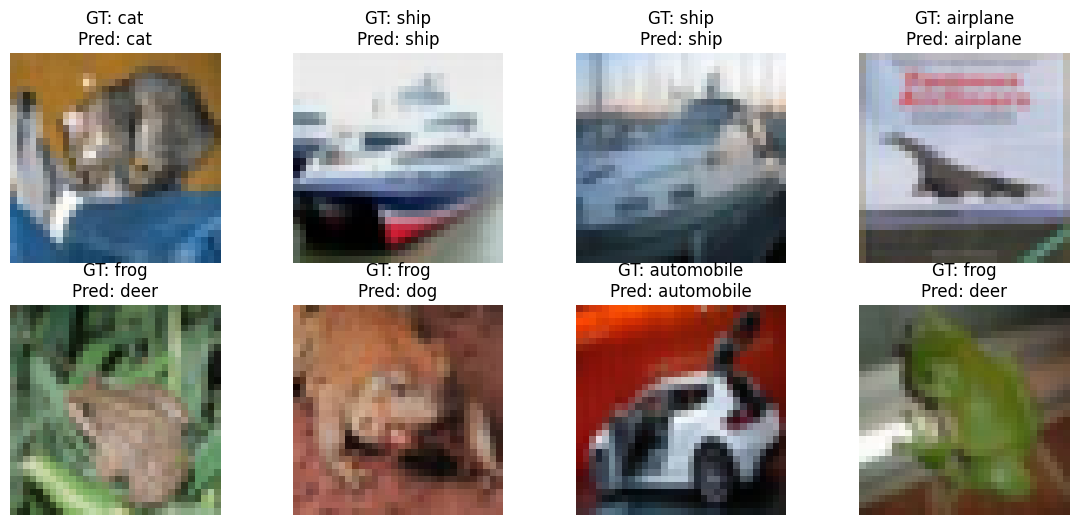

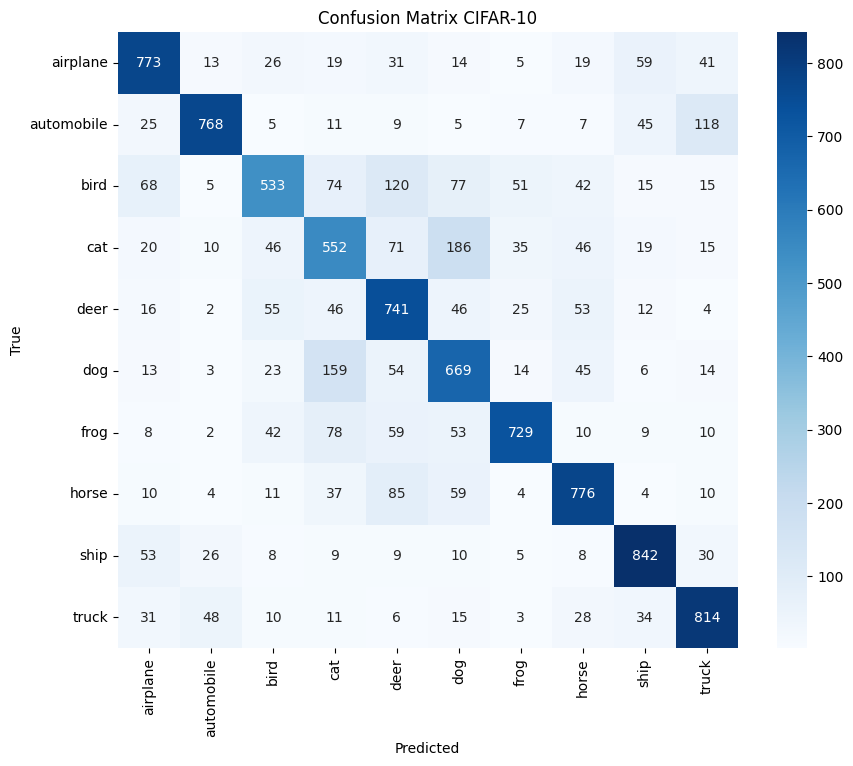

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [32,16,16]
        x = self.pool(F.relu(self.conv2(x)))  # [64,8,8]
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print("Device:", device)
print(model)

LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

epochs = 10
train_losses, test_accuracies = [], []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    test_accuracies.append(acc)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"⚡ Learning rate giảm từ {old_lr:.6f} → {new_lr:.6f}")

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

print("Huấn luyện xong!")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()
plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images[:8].to(device), labels[:8].to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

plt.figure(figsize=(14,6))
for i in range(8):
    img = images[i].cpu().permute(1,2,0).numpy()
    img = (img * 0.5 + 0.5).clip(0,1)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
plt.show()

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix CIFAR-10")
plt.show()
